# Forex Time-Series Prediction Using TCN

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

Kerasから必要なライブラリをインポートする

In [2]:
from model.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
pd.__version__

'0.25.1'

## Load Data

In [6]:
%%time
file_name="USDJPY_1min_201901_201907_macd.csv"
raw_forex_df = pd.read_csv(os.path.join("data", file_name), 
            dtype={"ema": float,"ema_12": float,"ema_26": float,"MACD": float,"MACD_signal": float})                  

CPU times: user 782 ms, sys: 283 ms, total: 1.06 s
Wall time: 1.06 s


List of the columns used in the data-set.

In [7]:
raw_forex_df.columns

Index(['datetime_stamp', 'mid', 'MA_5min', 'MA_8min', 'MA_13min', 'MA_1hour',
       'MA_1day', 'MA_5day', 'STD_5min', 'STD_8min', 'STD_13min', 'STD_1hour',
       'STD_1day', 'STD_5day', 'momentum', 'MA_20min', 'STD_20min',
       'upper_band', 'lower_band', 'ema', 'ema_12', 'ema_26', 'MACD',
       'MACD_signal'],
      dtype='object')

These are the top rows of the data-set.

In [8]:
raw_forex_df.head(61)

,datetime_stamp,mid,MA_5min,MA_8min,MA_13min,MA_1hour,MA_1day,MA_5day,STD_5min,STD_8min,...,momentum,MA_20min,STD_20min,upper_band,lower_band,ema,ema_12,ema_26,MACD,MACD_signal
0,2019-01-01 17:00:00,109.6685,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,109.668500,109.668500,109.668500,0.000000,0.000000
1,2019-01-01 17:01:00,109.6700,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1.500000e-03,0.000000,0.000000,0.000000,0.000000,109.669625,109.669313,109.669279,0.000034,0.000019
2,2019-01-01 17:02:00,109.6700,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,109.669885,109.669581,109.669538,0.000043,0.000029
3,2019-01-01 17:03:00,109.6700,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,-1.421085e-14,0.000000,0.000000,0.000000,0.000000,109.669962,109.669713,109.669667,0.000046,0.000035
4,2019-01-01 17:04:00,109.6695,109.6696,0.000000,0.000000,0.000000,0.0,0.0,0.000652,0.000000,...,-5.000000e-04,0.000000,0.000000,0.000000,0.000000,109.669653,109.669655,109.669628,0.000027,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2019-01-01 17:56:00,109.6840,109.6845,109.686500,109.687192,0.000000,0.0,0.0,0.004730,0.004899,...,1.500000e-03,109.681075,0.010259,109.701593,109.660557,109.683616,109.683716,109.677711,0.006005,0.006984
57,2019-01-01 17:57:00,109.6865,109.6833,109.685688,109.687846,0.000000,0.0,0.0,0.002361,0.004148,...,2.500000e-03,109.681875,0.010012,109.701898,109.661852,109.685539,109.684145,109.678370,0.005775,0.006742
58,2019-01-01 17:58:00,109.6845,109.6842,109.684938,109.688423,0.000000,0.0,0.0,0.001483,0.003669,...,-2.000000e-03,109.682650,0.009552,109.701754,109.663546,109.684846,109.684199,109.678829,0.005370,0.006468
59,2019-01-01 17:59:00,109.6905,109.6856,109.685500,109.687731,109.667875,0.0,0.0,0.003090,0.004166,...,6.000000e-03,109.683700,0.009177,109.702054,109.665346,109.688615,109.685169,109.679702,0.005467,0.006267


In [9]:
raw_forex_df.drop(columns=['MA_1day', 'MA_5day'], inplace=True)
raw_forex_df.columns

Index(['datetime_stamp', 'mid', 'MA_5min', 'MA_8min', 'MA_13min', 'MA_1hour',
       'STD_5min', 'STD_8min', 'STD_13min', 'STD_1hour', 'STD_1day',
       'STD_5day', 'momentum', 'MA_20min', 'STD_20min', 'upper_band',
       'lower_band', 'ema', 'ema_12', 'ema_26', 'MACD', 'MACD_signal'],
      dtype='object')

In [10]:
raw_forex_df = raw_forex_df[60:]

In [11]:
raw_forex_df.head(10)

,datetime_stamp,mid,MA_5min,MA_8min,MA_13min,MA_1hour,STD_5min,STD_8min,STD_13min,STD_1hour,...,momentum,MA_20min,STD_20min,upper_band,lower_band,ema,ema_12,ema_26,MACD,MACD_signal
60,2019-01-01 18:00:00,109.6815,109.6854,109.684125,109.686731,109.668092,0.003362,0.003238,0.004549,0.015556,...,-0.0090,109.684425,0.008321,109.701068,109.667782,109.683872,109.684604,109.679836,0.004768,0.005967
61,2019-01-01 18:01:00,109.6780,109.6842,109.683875,109.685615,109.668225,0.004764,0.003652,0.004788,0.015607,...,-0.0035,109.684825,0.007765,109.700355,109.669295,109.679957,109.683588,109.679699,0.003889,0.005552
62,2019-01-01 18:02:00,109.6665,109.6802,109.681750,109.683577,109.668167,0.008927,0.007161,0.006658,0.015606,...,-0.0115,109.684675,0.008099,109.700872,109.668478,109.670986,109.680959,109.678714,0.002245,0.004890
63,2019-01-01 18:03:00,109.6580,109.6749,109.678688,109.681077,109.667967,0.012774,0.011003,0.009385,0.015659,...,-0.0085,109.683950,0.009730,109.703411,109.664489,109.662329,109.677427,109.677168,0.000259,0.003964
64,2019-01-01 18:04:00,109.6585,109.6685,109.675500,109.678962,109.667783,0.010880,0.012792,0.011121,0.015705,...,0.0005,109.682975,0.011221,109.705417,109.660533,109.659776,109.674515,109.675776,-0.001261,0.002919
65,2019-01-01 18:05:00,109.6665,109.6655,109.673000,109.676962,109.667733,0.008116,0.012279,0.010818,0.015704,...,0.0080,109.682450,0.011748,109.705947,109.658953,109.664259,109.673282,109.675085,-0.001803,0.001975
66,2019-01-01 18:06:00,109.6885,109.6676,109.673500,109.677615,109.668050,0.012392,0.012881,0.011264,0.015931,...,0.0220,109.681900,0.011150,109.704201,109.659599,109.680420,109.675623,109.676084,-0.000461,0.001488
67,2019-01-01 18:07:00,109.6730,109.6689,109.671313,109.676808,109.668100,0.012587,0.010918,0.011183,0.015942,...,-0.0155,109.680825,0.010905,109.702636,109.659014,109.675473,109.675220,109.675854,-0.000635,0.001063
68,2019-01-01 18:08:00,109.6650,109.6703,109.669250,109.675462,109.668083,0.011405,0.010257,0.011490,0.015944,...,-0.0080,109.679450,0.011088,109.701626,109.657274,109.668491,109.673647,109.675046,-0.001399,0.000571
69,2019-01-01 18:09:00,109.6695,109.6725,109.668188,109.674346,109.668192,0.009454,0.009643,0.011294,0.015931,...,0.0045,109.678275,0.010818,109.699912,109.656638,109.669164,109.673009,109.674634,-0.001624,0.000132


There are 24 input-signals in the data-set.

In [12]:
raw_forex_df['datetime_stamp'] = pd.to_datetime(raw_forex_df['datetime_stamp'], infer_datetime_format=True)
raw_forex_df.set_index('datetime_stamp', inplace=True)
raw_forex_df = raw_forex_df.astype('float32')

In [13]:
raw_forex_df.values.shape

(205590, 21)

In [14]:
dataset = raw_forex_df[:4000000]
#dataset.set_index('datetime_stamp', inplace=True)
dataset.head()

,mid,MA_5min,MA_8min,MA_13min,MA_1hour,STD_5min,STD_8min,STD_13min,STD_1hour,STD_1day,...,momentum,MA_20min,STD_20min,upper_band,lower_band,ema,ema_12,ema_26,MACD,MACD_signal
datetime_stamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 18:00:00,109.681503,109.685402,109.684128,109.686729,109.668091,0.003362,0.003238,0.004549,0.015556,0.0,...,-0.0090,109.684425,0.008321,109.701065,109.667786,109.683868,109.684601,109.679840,0.004768,0.005967
2019-01-01 18:01:00,109.678001,109.684196,109.683876,109.685616,109.668228,0.004764,0.003652,0.004788,0.015607,0.0,...,-0.0035,109.684822,0.007765,109.700356,109.669296,109.679955,109.683586,109.679703,0.003889,0.005552
2019-01-01 18:02:00,109.666496,109.680199,109.681747,109.683578,109.668167,0.008927,0.007161,0.006658,0.015606,0.0,...,-0.0115,109.684677,0.008099,109.700874,109.668480,109.670982,109.680962,109.678711,0.002245,0.004890
2019-01-01 18:03:00,109.657997,109.674896,109.678688,109.681076,109.667969,0.012774,0.011003,0.009385,0.015659,0.0,...,-0.0085,109.683952,0.009730,109.703407,109.664490,109.662331,109.677429,109.677170,0.000259,0.003964
2019-01-01 18:04:00,109.658501,109.668503,109.675499,109.678963,109.667786,0.010880,0.012792,0.011121,0.015705,0.0,...,0.0005,109.682976,0.011221,109.705414,109.660530,109.659775,109.674515,109.675774,-0.001261,0.002919


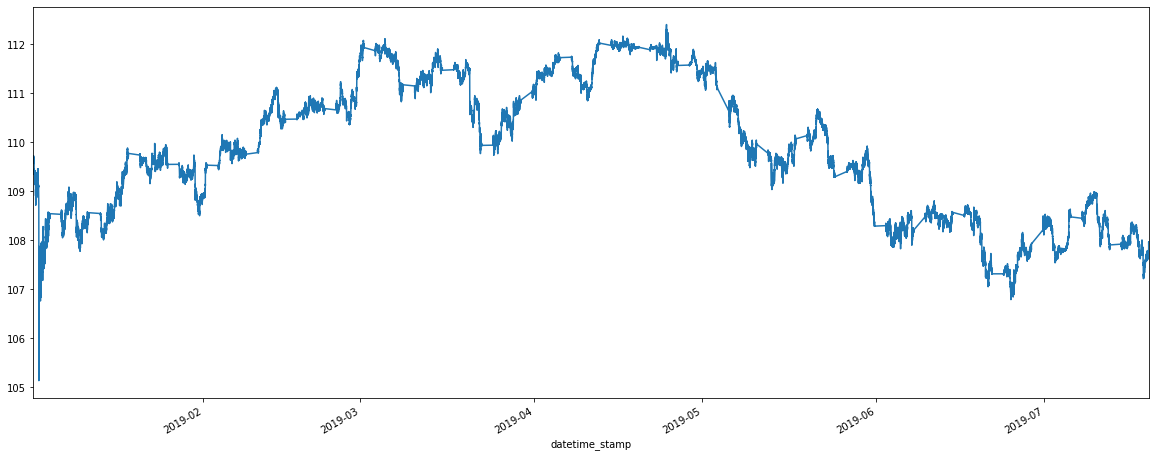

In [15]:
#raw_forex_df['mid'].plot(figsize=(20,8))
dataset['mid'].plot(figsize=(20,8))

# Split dataset to train, test dataset

In [16]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, train_size=0.9, test_size=0.1, shuffle=False)

In [17]:
print("Train and test size=", len(df_train), len(df_test))

Train and test size= 185031 20559


In [18]:
df_train.head(5)

,mid,MA_5min,MA_8min,MA_13min,MA_1hour,STD_5min,STD_8min,STD_13min,STD_1hour,STD_1day,...,momentum,MA_20min,STD_20min,upper_band,lower_band,ema,ema_12,ema_26,MACD,MACD_signal
datetime_stamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 18:00:00,109.681503,109.685402,109.684128,109.686729,109.668091,0.003362,0.003238,0.004549,0.015556,0.0,...,-0.0090,109.684425,0.008321,109.701065,109.667786,109.683868,109.684601,109.679840,0.004768,0.005967
2019-01-01 18:01:00,109.678001,109.684196,109.683876,109.685616,109.668228,0.004764,0.003652,0.004788,0.015607,0.0,...,-0.0035,109.684822,0.007765,109.700356,109.669296,109.679955,109.683586,109.679703,0.003889,0.005552
2019-01-01 18:02:00,109.666496,109.680199,109.681747,109.683578,109.668167,0.008927,0.007161,0.006658,0.015606,0.0,...,-0.0115,109.684677,0.008099,109.700874,109.668480,109.670982,109.680962,109.678711,0.002245,0.004890
2019-01-01 18:03:00,109.657997,109.674896,109.678688,109.681076,109.667969,0.012774,0.011003,0.009385,0.015659,0.0,...,-0.0085,109.683952,0.009730,109.703407,109.664490,109.662331,109.677429,109.677170,0.000259,0.003964
2019-01-01 18:04:00,109.658501,109.668503,109.675499,109.678963,109.667786,0.010880,0.012792,0.011121,0.015705,0.0,...,0.0005,109.682976,0.011221,109.705414,109.660530,109.659775,109.674515,109.675774,-0.001261,0.002919


### Scaled Data

The data-set contains a wide range of values:

In [19]:
df_test.head(5)

,mid,MA_5min,MA_8min,MA_13min,MA_1hour,STD_5min,STD_8min,STD_13min,STD_1hour,STD_1day,...,momentum,MA_20min,STD_20min,upper_band,lower_band,ema,ema_12,ema_26,MACD,MACD_signal
datetime_stamp,,,,,,,,,,,,,,,,,,,,,
2019-07-01 10:19:00,108.333000,108.335999,108.346436,108.343536,108.308487,0.013435,0.017871,0.014964,0.032421,0.226982,...,0.009,108.342278,0.023114,108.388504,108.296051,108.330917,108.339005,108.330467,0.008531,0.012560
2019-07-01 10:20:00,108.324997,108.330002,108.341499,108.341927,108.308357,0.008689,0.017623,0.015787,0.032341,0.226733,...,-0.008,108.345253,0.015179,108.375610,108.314888,108.326973,108.336845,108.330063,0.006783,0.011404
2019-07-01 10:21:00,108.323997,108.325996,108.337250,108.340233,108.308205,0.003937,0.017169,0.016478,0.032246,0.226442,...,-0.001,108.344551,0.015840,108.376228,108.312874,108.324989,108.334869,108.329613,0.005255,0.010174
2019-07-01 10:22:00,108.330002,108.327202,108.332375,108.340347,108.308327,0.004087,0.011451,0.016394,0.032313,0.226170,...,0.006,108.344101,0.016131,108.376358,108.311836,108.328331,108.334122,108.329643,0.004477,0.009035
2019-07-01 10:23:00,108.320000,108.326401,108.328003,108.339462,108.308441,0.005128,0.007616,0.017202,0.032343,0.225918,...,-0.010,108.341423,0.015419,108.372261,108.310585,108.322777,108.331947,108.328934,0.003019,0.007832


In [20]:
print("Min:", np.min(df_train))
print("Max:", np.max(df_train))

Min: mid            105.135002
MA_5min        105.363503
MA_8min        105.632126
MA_13min       105.941460
MA_1hour       106.846375
STD_5min         0.000000
STD_8min         0.000000
STD_13min        0.000000
STD_1hour        0.000000
STD_1day         0.000000
STD_5day         0.000000
momentum        -1.518500
MA_20min       106.204750
STD_20min        0.000001
upper_band     106.834648
lower_band     104.176270
ema            105.242165
ema_12         106.388313
ema_26         106.820290
MACD            -0.905614
MACD_signal     -0.706804
dtype: float32
Max: mid            112.399002
MA_5min        112.391296
MA_8min        112.382874
MA_13min       112.372612
MA_1hour       112.330139
STD_5min         1.323447
STD_8min         1.487600
STD_13min        1.570637
STD_1hour        1.274778
STD_1day         0.977363
STD_5day         0.656655
momentum         0.559000
MA_20min       112.360748
STD_20min        1.511598
upper_band     112.411354
lower_band     112.319542
ema          

The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [21]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [22]:
df_x_train_scaled = x_scaler.fit_transform(df_train)
df_x_train_scaled[0:5]

array([[0.62589499, 0.61497242, 0.6002301 , 0.58236372, 0.51455824,
        0.00253999, 0.0021764 , 0.0028962 , 0.01220264, 0.        ,
        0.        , 0.72659446, 0.56524956, 0.0055043 , 0.51399822,
        0.67436233, 0.62083891, 0.55097021, 0.51782655, 0.8427443 ,
        0.83256743],
       [0.6254129 , 0.61480089, 0.6001928 , 0.58219051, 0.51458329,
        0.00360003, 0.00245516, 0.00304832, 0.01224252, 0.        ,
        0.        , 0.72924187, 0.56531401, 0.00513634, 0.51387099,
        0.67454783, 0.62029185, 0.5508006 , 0.51780168, 0.84193072,
        0.83208187],
       [0.62382904, 0.61423204, 0.59987749, 0.58187377, 0.51457216,
        0.00674563, 0.00481407, 0.00423895, 0.01224236, 0.        ,
        0.        , 0.72539109, 0.56529046, 0.00535693, 0.51396402,
        0.67444758, 0.61903777, 0.55036191, 0.51762208, 0.84040926,
        0.83130946],
       [0.62265901, 0.61347754, 0.5994243 , 0.58148465, 0.51453598,
        0.00965206, 0.00739651, 0.00597524, 0.0122838

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [23]:
print("Min:", np.min(df_x_train_scaled))
print("Max:", np.max(df_x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [24]:
df_x_test_scaled = x_scaler.transform(df_test)
df_x_test_scaled[0:5]

array([[0.44025304, 0.42296289, 0.40207542, 0.37350643, 0.26662567,
        0.01015154, 0.01201361, 0.00952765, 0.02543272, 0.23223948,
        0.60418851, 0.73525872, 0.34722678, 0.01529033, 0.27863329,
        0.50591228, 0.43173025, 0.32605552, 0.27347308, 0.8462283 ,
        0.84026755],
       [0.43915127, 0.42210961, 0.40134421, 0.37325611, 0.26660202,
        0.00656549, 0.01184662, 0.01005162, 0.02537012, 0.23198475,
        0.6042997 , 0.7270758 , 0.34771013, 0.01004116, 0.27632123,
        0.50822547, 0.43117892, 0.32569463, 0.27339985, 0.84460927,
        0.83891794],
       [0.43901368, 0.42153967, 0.40071471, 0.37299275, 0.26657419,
        0.00297481, 0.01154163, 0.01049131, 0.02529521, 0.23168674,
        0.60441058, 0.73044524, 0.34759611, 0.01047803, 0.27643204,
        0.50797813, 0.43090166, 0.32536434, 0.27331834, 0.84319541,
        0.83748144],
       [0.43984027, 0.42171119, 0.39999254, 0.37301054, 0.26659645,
        0.00308782, 0.00769762, 0.01043786, 0.0253477

### Target Data for Prediction

We will try and predict the future mid-price for this commodity pair.

In [25]:
target_column_index = 0 #'mid'
target_names = [target_column_index]

In [26]:
lookback_window = 512 # Number of minutes.
lookback_window

512

In [27]:
from tqdm import tqdm_notebook
def build_timeseries(dataset, target_column_index, time_steps):
    # Total number of time-series samples would be len(dataset) - time_steps
    dim_0 = dataset.shape[0] - time_steps
    print(dim_0)
    dim_1 = dataset.shape[1]
    print(dim_1)
    
    # Init the x, y matrix
    x = np.zeros((dim_0, time_steps, dim_1))
    # Number of output variables is 1 for this mid price prediction
    y = np.zeros((dim_0, 1) )
    
    # fill data to x, y
    for i in tqdm_notebook(range(dim_0)):
        x[i] = dataset[i: i + time_steps]
        y[i] = dataset[i + time_steps, target_column_index]
    
    print("Lenght of time-series x, y", x.shape, y.shape)
    return x, y

### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

Create a new data-frame with the time-shifted data.

**Note the negative time-shift!**

In [28]:
#df_targets = raw_forex_df[target_column].shift(-lookback_window)
x_train_scaled, y_train_scaled = build_timeseries(df_x_train_scaled, target_column_index, lookback_window)

184519
21



Lenght of time-series x, y (184519, 512, 21) (184519, 1)


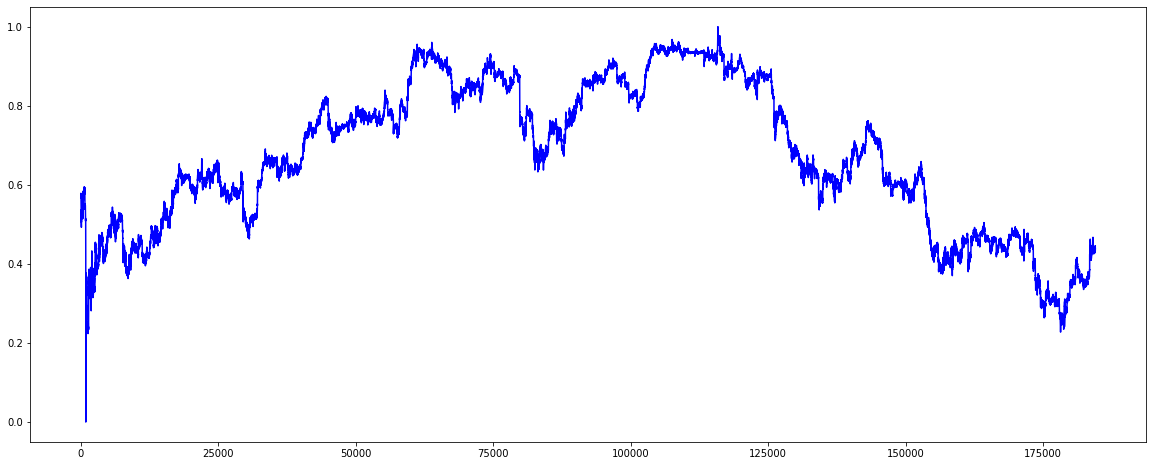

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(y_train_scaled, color='blue')
plt.show()

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. We can check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first `lookback_window + 5` rows of the original data-frame:

In [30]:
x_train_scaled[lookback_window:lookback_window+5][0]

array([[0.56697409, 0.55277605, 0.53448669, ..., 0.43580756, 0.84574617,
        0.82910201],
       [0.56910725, 0.55363042, 0.53532979, ..., 0.43637125, 0.84771344,
        0.83076888],
       [0.56890139, 0.5543556 , 0.53607908, ..., 0.43687414, 0.84903706,
        0.83243641],
       ...,
       [0.57151665, 0.56004742, 0.54658727, ..., 0.45545918, 0.82489215,
        0.81904985],
       [0.57089697, 0.55852432, 0.54478241, ..., 0.45474214, 0.82301371,
        0.81649384],
       [0.56952107, 0.55750059, 0.54301372, ..., 0.45394497, 0.82097811,
        0.81393532]])

The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [31]:
print(type(x_train_scaled))
print("Shape:", x_train_scaled.shape)

<class 'numpy.ndarray'>
Shape: (184519, 512, 21)


These are the output-signals (or target-signals):

In [32]:
print(type(y_train_scaled))
print("Shape:", y_train_scaled.shape)

<class 'numpy.ndarray'>
Shape: (184519, 1)


This is the number of observations (aka. data-points or samples) in the data-set:

In [33]:
num_train = len(x_train_scaled)
num_train

184519

In [34]:
x_test_scaled, y_test_scaled  = build_timeseries(df_x_test_scaled, target_column_index, lookback_window)

20047
21



Lenght of time-series x, y (20047, 512, 21) (20047, 1)


These are the input-signals for the training- and test-sets:

In [35]:
len(x_train_scaled) + len(x_test_scaled)

204566

These are the output-signals for the training- and test-sets:

In [36]:
len(y_train_scaled) + len(y_test_scaled)

204566

This is the number of input-signals:

In [37]:
num_x_signals = x_train_scaled.shape[2]
num_x_signals

21

This is the number of output-signals:

In [38]:
num_y_signals = y_train_scaled.shape[1]# Mid Price 
num_y_signals

1

## Data Generator

These are the array-shapes of the input and output data:

In [39]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(184519, 512, 21)
(184519, 1)


In [40]:
batch_size = 256

In [41]:
sequence_length = lookback_window
sequence_length

512

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [42]:
validation_data = (x_test_scaled, y_test_scaled)

## Create the Temporal Convolutional Neural Network

We are now ready to create the Temporal Convolutional Neural Network (TCN). We will use the Keras API for this because of its simplicity. 

This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [43]:
i = Input(shape=(lookback_window, num_x_signals, ))
m = TCN(nb_stacks=1)(i)
m = Dense(num_y_signals, activation='linear')(m)

W0922 02:55:46.263929 140095523002176 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [44]:
i

<tf.Tensor 'input_1:0' shape=(?, 512, 21) dtype=float32>

In [45]:
m

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [46]:
model = Model(inputs=[i], outputs=[m])

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [49]:
optimizer = RMSprop(lr=1e-4)

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

We then compile the Keras model so it is ready for training.

In [50]:
#model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['mae', 'mse'])
model.compile(optimizer=optimizer,
              loss='mse',  
              metrics=['mae'])

This is a very small model with only two layers. The output shape of `(None, None, 3)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 3 signals. This corresponds to the 3 target signals we want to predict.

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 64)      1408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 64)      8256        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 64)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [52]:
path_checkpoint = 'alpha_trader_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [53]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [54]:
from datetime import datetime
logdir="/tf/alpha-trader/source/logs/fit/" + datetime.today().strftime("%Y%m%d-%H%M%S")
callback_tensorboard = TensorBoard(log_dir=logdir,
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [55]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

In [56]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard
             ,callback_reduce_lr
            ]

## Train the Temporal Convolution Neural Network (TCN)

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [57]:
!nvidia-smi

Sun Sep 22 02:55:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   46C    P0    53W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [58]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [60]:
%%time
model.fit(x_train_scaled, 
          y_train_scaled, 
          epochs=30, 
          validation_split = 0.1,
          shuffle=True,
          callbacks=callbacks)

Train on 166067 samples, validate on 18452 samples
Epoch 1/30
165952/166067 [============================>.] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0430
Epoch 00001: val_loss improved from inf to 0.00035, saving model to alpha_trader_checkpoint.keras
166067/166067 [==============================] - 80s 481us/sample - loss: 0.0035 - mean_absolute_error: 0.0430 - val_loss: 3.4900e-04 - val_mean_absolute_error: 0.0137
Epoch 2/30
166048/166067 [============================>.] - ETA: 0s - loss: 4.4827e-04 - mean_absolute_error: 0.0166
Epoch 00002: val_loss improved from 0.00035 to 0.00032, saving model to alpha_trader_checkpoint.keras

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1e-05.
166067/166067 [==============================] - 77s 465us/sample - loss: 4.4827e-04 - mean_absolute_error: 0.0166 - val_loss: 3.1790e-04 - val_mean_absolute_error: 0.0169
Epoch 3/30
166048/166067 [============================>.] - ETA: 0s - loss: 2.9954e-05 - mean_absolute_error: 0.00

Epoch 23/30
165920/166067 [============================>.] - ETA: 0s - loss: 5.8288e-06 - mean_absolute_error: 0.0017
Epoch 00023: val_loss improved from 0.00006 to 0.00005, saving model to alpha_trader_checkpoint.keras
166067/166067 [==============================] - 77s 462us/sample - loss: 5.8266e-06 - mean_absolute_error: 0.0017 - val_loss: 4.7405e-05 - val_mean_absolute_error: 0.0050
Epoch 24/30
166016/166067 [============================>.] - ETA: 0s - loss: 5.6887e-06 - mean_absolute_error: 0.0017
Epoch 00024: val_loss did not improve from 0.00005
166067/166067 [==============================] - 79s 473us/sample - loss: 5.6880e-06 - mean_absolute_error: 0.0017 - val_loss: 5.0046e-05 - val_mean_absolute_error: 0.0049
Epoch 25/30
165984/166067 [============================>.] - ETA: 0s - loss: 5.6841e-06 - mean_absolute_error: 0.0017
Epoch 00025: val_loss did not improve from 0.00005
166067/166067 [==============================] - 79s 473us/sample - loss: 5.6843e-06 - mean_absolu

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [61]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [62]:
result = model.evaluate(x_test_scaled, y_test_scaled)

20047/20047 [==============================] - 6s 298us/sample - loss: 3.0293e-05 - mean_absolute_error: 0.0042


In [63]:
print("loss (test-set):", result)

loss (test-set): [3.0292647233143678e-05, 0.004238235]


In [64]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [74]:
import seaborn as sns
def plot_comparison(y_train, y_test, y_scaler_min, y_scaler_max, lookback_window, start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[lookback_window+ start_idx:lookback_window+end_idx]
    
    # Input-signals for the model.
   # x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    #y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    y_pred_rescaled = y_pred*(y_scaler_max - y_scaler_min) + y_scaler_min
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        #signal_true = y_true[:, signal]
        signal_true = y_true

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(20,8))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
        
        # Some more benchmark
        diff = signal_pred - signal_true
        fig, ax = plt.subplots(figsize=(20, 8))
        sns.distplot(diff, kde=True, rug=True)
        ax.set_xlim(-0.25, 0.25)
        plt.title('Distribution of differences between actual and prediction ')
        plt.show()

We can now plot an example of predicted output-signals. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [75]:
y_train_mid_min = np.min(df_train)["mid"]
y_train_mid_max = np.max(df_train)["mid"]

print("y_min={0}, y_max={1}, range={2}", y_train_mid_min, y_train_mid_max, y_train_mid_max - y_train_mid_min)

y_min={0}, y_max={1}, range={2} 105.135 112.399 7.264


In [76]:
y_train = df_train["mid"].values
y_train

array([109.6815, 109.678 , 109.6665, ..., 108.344 , 108.324 , 108.324 ],
      dtype=float32)

In [77]:
y_test = df_test["mid"].values
y_test

array([108.333 , 108.325 , 108.324 , ..., 107.7315, 107.7345, 107.745 ],
      dtype=float32)

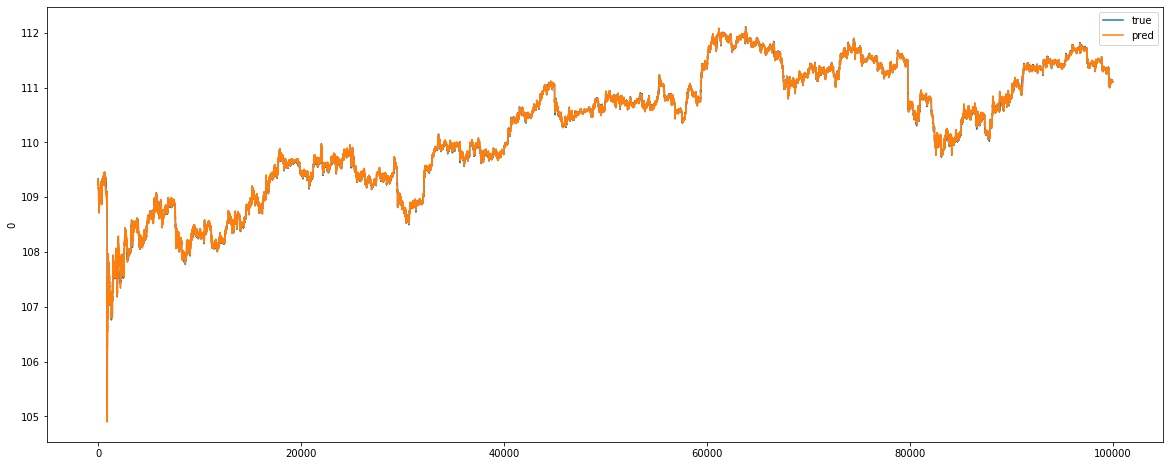

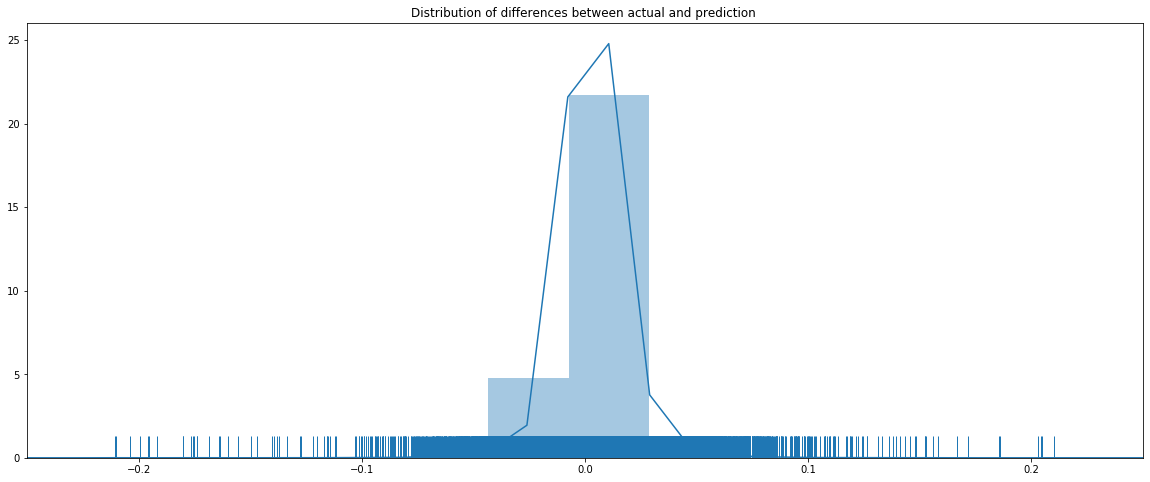

In [79]:
plot_comparison(y_train, y_test, y_train_mid_min, y_train_mid_max, lookback_window, start_idx=0, length=100000, train=True)

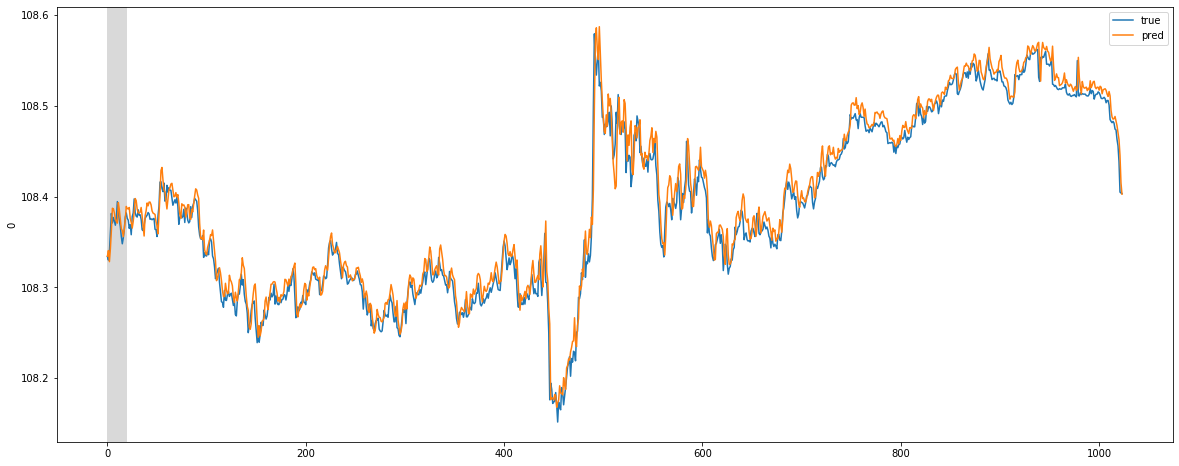

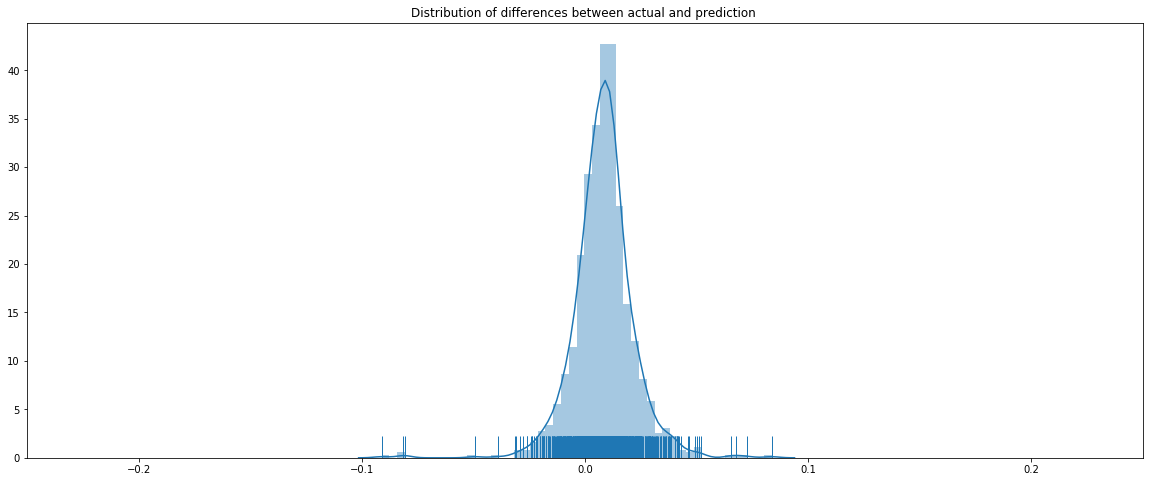

In [80]:
plot_comparison(y_train, y_test, y_train_mid_min, y_train_mid_max, lookback_window, start_idx=10000, length=1024, train=True)

The model was able to predict the overall inaccurate...

### Strange Example

The following is another example from the training-set.

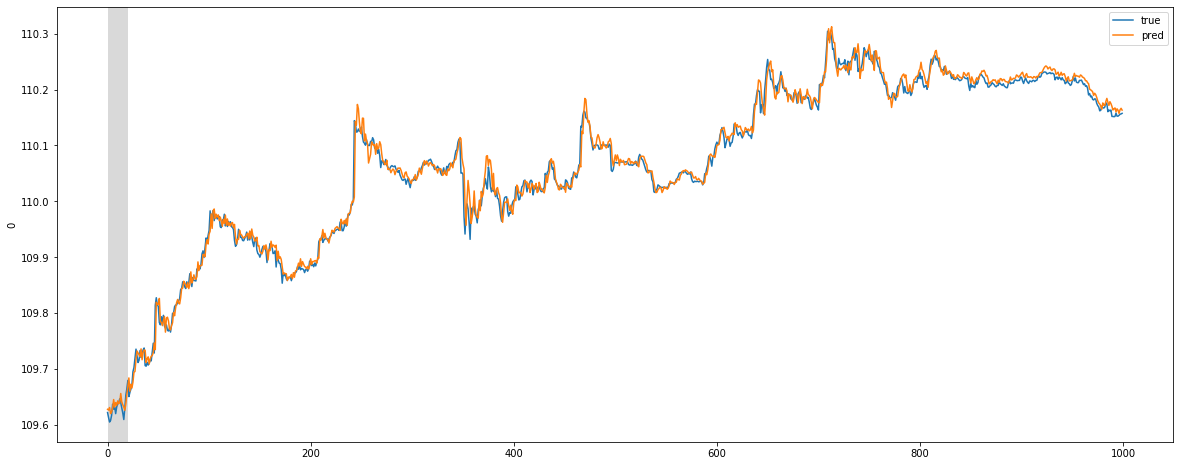

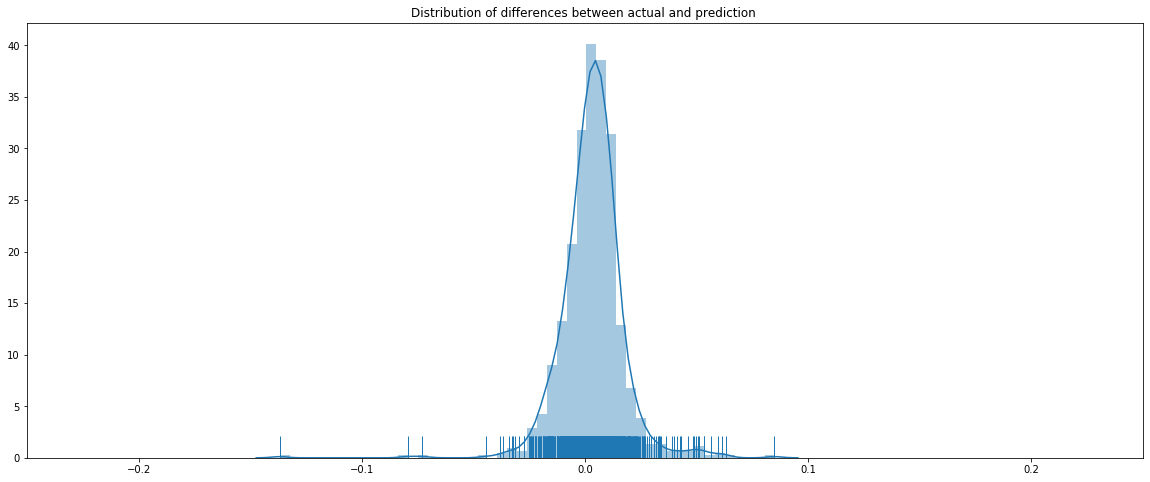

In [81]:
plot_comparison(y_train, y_test, y_train_mid_min, y_train_mid_max, lookback_window, start_idx=140000, length=1000, train=True)

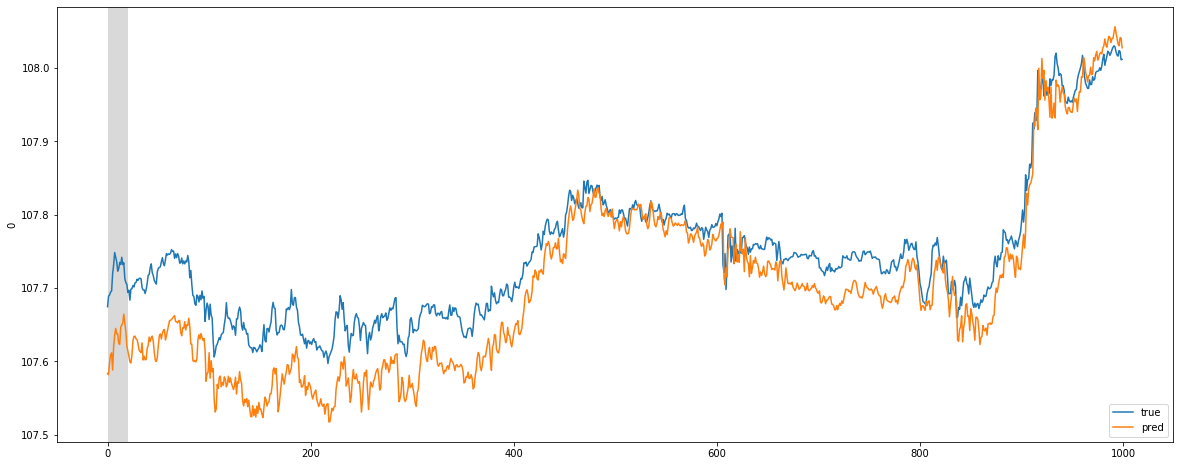

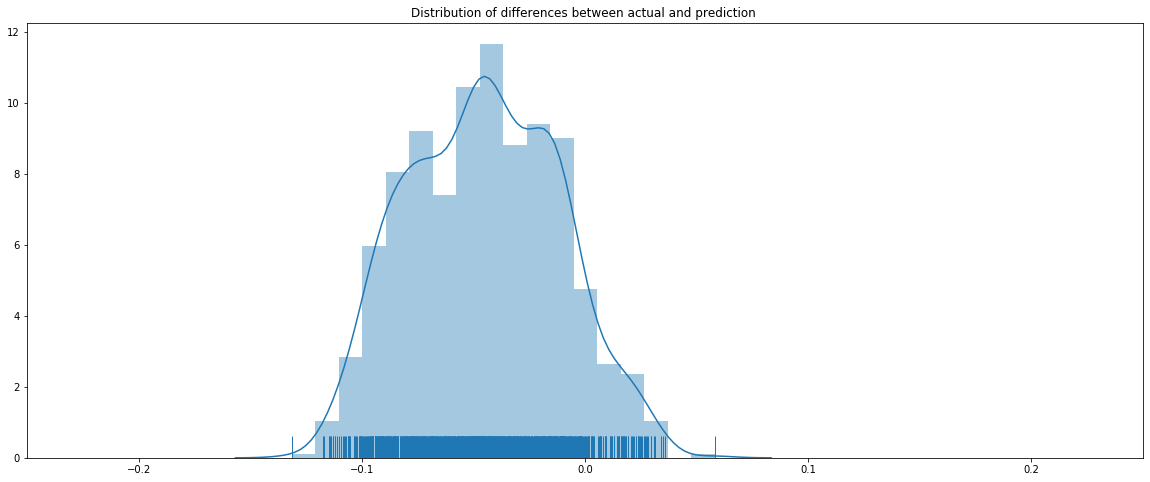

In [82]:
plot_comparison(y_train, y_test, y_train_mid_min, y_train_mid_max, lookback_window, start_idx=180000, length=1000, train=True)

### Example from Test-Set

Now consider an example from the test-set. The model has not seen this data during training.

The mid-price is predicted reasonably well, although the peaks are sometimes inaccurate.

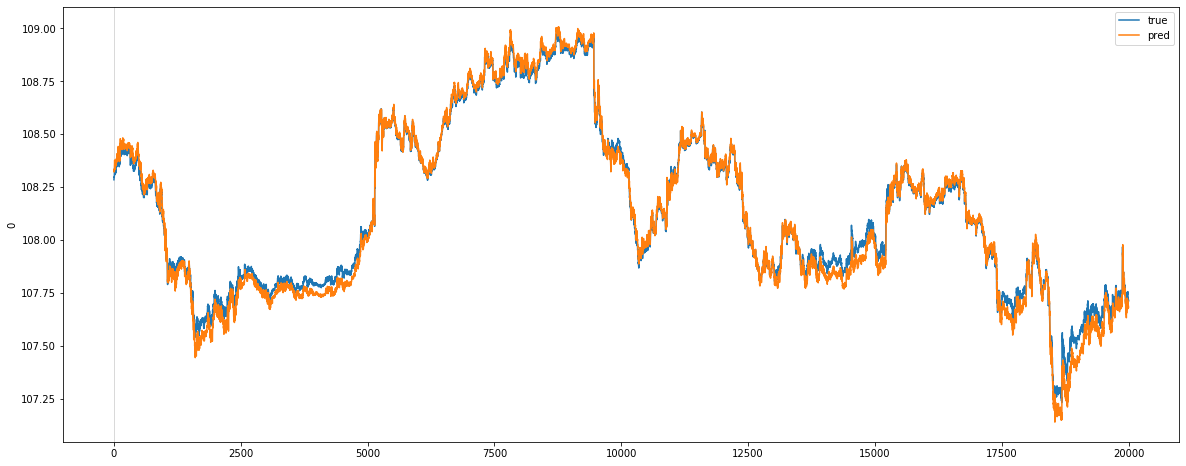

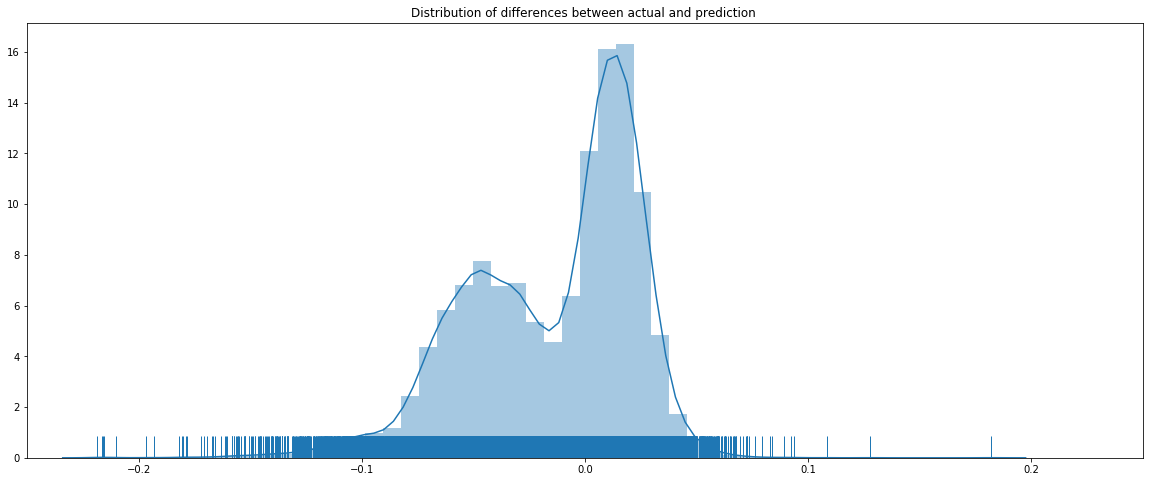

In [84]:
plot_comparison(y_train, y_test, y_train_mid_min, y_train_mid_max, lookback_window, start_idx=0, length=20000, train=False)

## Conclusion

We used a Temporal Convolutional Neural Network to predict mid-price's Forex time-series from a number of input-signals. We used forex-data for 512 minutes to predict next 1 minute mid-price.

The result show that the mid-price could not be predicted very well at the beginning, but predicted the trend quite good later.

We can use this method with different time-series but you should be careful to distinguish between *causation and correlation* in the data. The neural network may easily discover patterns in the data that are only temporary correlations which do not generalize well to unseen data.

We should select input- and output-data where a *causal* relationship probably exists. We should have a lot of data available for training, and we should try and reduce the risk of over-fitting the model to the training-data, e.g. using early-stopping as we did in this notebook.